<a href="https://colab.research.google.com/github/sayanbanerjee32/multimodal_llm/blob/main/multimodal_inference_test_with_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers==4.44.2
!pip install -Uq accelerate

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gpq8ndzr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gpq8ndzr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=96a34e3dc93a96b46c925c99f0a75d186fb4cefe2aca510fb608103b34104cc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-49xvgp5v/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
# from audio_pipeline import AudioTranscriptionPipeline
import clip
from PIL import Image
import os
import json
import random
from huggingface_hub import hf_hub_download
import torch.nn as nn

In [4]:
# from huggingface_hub import HfApi

# api = HfApi()
# api.upload_folder(
#     folder_path='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
#     repo_id="sayanbanerjee32/multimodal-phi3-4k-instruct-llava",
#     repo_type="model",
#     delete_patterns = "*.safetensors",
#     # allow_patterns = "*.safetensors",
# )
# print("Model uploaded to Hugging Face Hub")

In [5]:
import subprocess
import os

def download_files():
    # URLs to download
    coco_url = "http://images.cocodataset.org/zips/train2017.zip"
    coco_zip = "train2017.zip"
    coco_dir = "train2017"
    llava_url = "https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json"
    llava_json = "llava_instruct_150k.json"

    # Download COCO dataset
    if not os.path.exists(coco_zip):
        print("Downloading COCO train2017 dataset...")
        subprocess.run(["wget", "-c", coco_url])
    else:
        print("COCO dataset already downloaded.")

    # Unzip COCO dataset
    if not os.path.exists(coco_dir):
        print("Unzipping the dataset...")
        subprocess.run(["unzip", "-q", coco_zip])
    else:
        print("COCO dataset already unzipped.")

    # Download LLaVA 150k instruction JSON file
    if not os.path.exists(llava_json):
        print("Downloading LLaVA 150k instruction JSON file...")
        subprocess.run(["wget", "-c", llava_url])
    else:
        print("LLaVA 150k instruction JSON file already downloaded.")

    print("All files have been downloaded and extracted.")

# Call the function to download files
download_files()

Unzipping the dataset...
All files have been downloaded and extracted.


In [6]:
import json
import random

def prepare_dataset(conversations):
    # Assuming conversations is a list of dictionaries with 'from' and 'value' keys
    # Process the conversations to create a single text input
    processed_text = ""
    expected_gt = ""
    for conv in conversations:
        if conv['from'] == 'human':
            processed_text += f"Human: {conv['value']}\n"
            break
    for conv in conversations:
        if conv['from'] == 'gpt':
            expected_gt += f"Assistant: {conv['value']}\n"
        # elif conv['from'] == 'gpt':
        #     processed_text += f"Assistant: {conv['value']}\n"
    return processed_text.strip(), expected_gt.strip()

def select_random_sample(json_file, coco_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Select a random sample
    sample = random.choice(data)
    image_name = sample['image']
    conversations = sample['conversations']

    # Process the text using the prepare_dataset function
    text, expected_op = prepare_dataset(conversations)

    # Construct the image path
    image_path = os.path.join(coco_dir, image_name)

    return image_path, text, expected_op

# Example usage
image_path, text, expected_op = select_random_sample("llava_instruct_150k.json", "train2017")
print(f"Selected image: {image_path}")
print(f"Corresponding text: {text}")
print(f"Expected output: {expected_op}")

Selected image: train2017/000000541771.jpg
Corresponding text: Human: <image>
What is this photo about'?
Expected output: Assistant: The image showcases a cozy living room setting featuring an entertainment center. In the room, there is a couch placed towards the right, and a television is positioned directly across from it. The TV is surrounded by multiple potted plants, creating a warm and inviting atmosphere. 

Additionally, there is a bookshelf with a collection of books and remote controls, showcasing the various entertainment options available in the room. A speaker system can also be inferred from the presence of the remote controls. There's also a coffee table, likely situated in front of the couch. Some potted plants are positioned around the room, adding a touch of greenery to space.


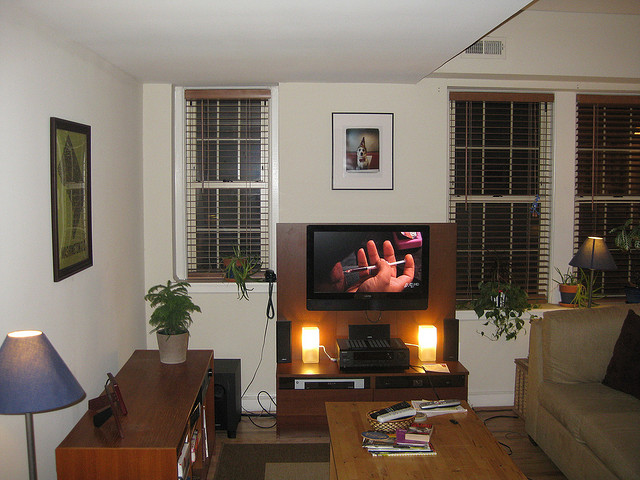

In [7]:
## lets see the image
img = Image.open(image_path)
display(img)

## Load model and generate

In [8]:
import gc
gc.collect()

0

In [9]:
class ImageProjector(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1024):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.GELU()  # Using GELU activation, but you can experiment with others
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.05)  # Adding dropout for regularization

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

class Phi3WithProjector(PreTrainedModel):
    supports_gradient_checkpointing = True

    def __init__(self, phi3_model, projector, debug=False):
        super().__init__(phi3_model.config)
        self.phi3 = phi3_model
        self.projector = projector
        self.debug = debug

    def debug_print(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, debug=False, **kwargs):
        # Load the base Phi-3 model
        phi3_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)

        # Determine if it's a local path or a Hugging Face model ID
        is_local = os.path.isdir(pretrained_model_name_or_path)

        if is_local:
            projector_path = os.path.join(pretrained_model_name_or_path, "image_projector.pth")
        else:
            try:
                # Try to download the projector weights from the Hugging Face Hub
                projector_path = hf_hub_download(repo_id=pretrained_model_name_or_path, filename="image_projector.pth")
            except Exception as e:
                print(f"Failed to download projector weights: {e}")
                projector_path = None

        if projector_path and os.path.exists(projector_path):
            projector_state_dict = torch.load(projector_path, map_location=phi3_model.device)

            # Check if the state dict has the expected structure
            if 'linear.weight' in projector_state_dict:
                input_dim = projector_state_dict['linear.weight'].size(1)
                output_dim = projector_state_dict['linear.weight'].size(0)
            else:
                # If not, try to infer dimensions from the first layer's weight
                first_key = next(iter(projector_state_dict))
                input_dim = projector_state_dict[first_key].size(1)
                output_dim = phi3_model.config.hidden_size  # Assuming this is the correct output dimension

            projector = ImageProjector(input_dim, output_dim)

            # Try to load the state dict, ignoring mismatched keys
            projector.load_state_dict(projector_state_dict, strict=False)
            print(f"Loaded projector with input_dim={input_dim}, output_dim={output_dim}")
        else:
            print(f"Projector weights not found. Initializing with default dimensions.")
            input_dim = 512  # Default CLIP embedding size
            output_dim = phi3_model.config.hidden_size
            projector = ImageProjector(input_dim, output_dim)

        # Create and return the Phi3WithProjector instance
        model = cls(phi3_model, projector, debug=debug)
        return model

    def save_pretrained(self, save_directory):
        # Save the base model
        self.phi3.save_pretrained(save_directory)

        # Save the projector weights
        projector_path = os.path.join(save_directory, "image_projector.pth")
        torch.save(self.projector.state_dict(), projector_path)

        # Save the config
        self.config.save_pretrained(save_directory)

    def forward(self, input_ids=None, attention_mask=None, image_embeddings=None, labels=None, past_key_values=None, **kwargs):
        device = next(self.parameters()).device

        if image_embeddings is not None:
            image_embeddings = image_embeddings.to(device)
            projected_images = self.projector(image_embeddings)
            projected_images = projected_images.unsqueeze(1)
            self.debug_print(f"forward projected_images: {projected_images.size()}")

            if past_key_values is None:  # This is the first forward pass
                self.debug_print(f"forward before: {attention_mask.size() if attention_mask is not None else None}")
                if 'inputs_embeds' in kwargs and kwargs['inputs_embeds'] is not None:
                    inputs_embeds = kwargs['inputs_embeds']
                    self.debug_print(f"forward before inputs_embeds: {inputs_embeds.size()}")
                    inputs_embeds = torch.cat([projected_images, inputs_embeds], dim=1)
                    kwargs['inputs_embeds'] = inputs_embeds
                    self.debug_print(f"forward after inputs_embeds: {inputs_embeds.size()}")
                elif input_ids is not None:
                    self.debug_print(f"forward input_ids: {input_ids.size()}")
                    inputs_embeds = self.get_input_embeddings()(input_ids.to(device))
                    self.debug_print(f"forward before inputs_embeds: {inputs_embeds.size()}")
                    inputs_embeds = torch.cat([projected_images, inputs_embeds], dim=1)
                    self.debug_print(f"forward after inputs_embeds: {inputs_embeds.size()}")
                    kwargs['inputs_embeds'] = inputs_embeds
                    input_ids = None  # Set to None to avoid conflict

                if attention_mask is not None:
                    attention_mask = torch.cat([torch.ones(image_embeddings.size(0), 1, device=device), attention_mask.to(device)], dim=1)
                else:
                    attention_mask = torch.ones(image_embeddings.size(0), inputs_embeds.size(1), device=device)

                if labels is not None:
                    # Adjust labels to match the new sequence length
                    labels = torch.cat([torch.full((labels.size(0), 1), -100, device=device), labels], dim=1)

        if labels is not None:
            labels = labels.to(device)

        # Determine sequence length
        if 'inputs_embeds' in kwargs and kwargs['inputs_embeds'] is not None:
            seq_length = kwargs['inputs_embeds'].size(1)
        elif input_ids is not None:
            seq_length = input_ids.size(1)
        else:
            seq_length = attention_mask.size(1) if attention_mask is not None else None

        if seq_length is None:
            raise ValueError("Unable to determine sequence length. Provide either input_ids, inputs_embeds, or attention_mask.")

        # Ensure attention_mask matches the sequence length
        if attention_mask is not None:
            attention_mask = attention_mask[:, :seq_length]

        self.debug_print(f"forward final: input_ids shape: {input_ids.shape if input_ids is not None else None}")
        self.debug_print(f"forward final: attention_mask shape: {attention_mask.shape if attention_mask is not None else None}")
        self.debug_print(f"forward final: inputs_embeds shape: {kwargs.get('inputs_embeds', {}).shape if kwargs.get('inputs_embeds') is not None else None}")

        return self.phi3(input_ids=input_ids, attention_mask=attention_mask, labels=labels, past_key_values=past_key_values, **kwargs)

    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, **kwargs):
        inputs = self.phi3.prepare_inputs_for_generation(input_ids, past=past, attention_mask=attention_mask, **kwargs)

        if 'image_embeddings' in kwargs:
            inputs['image_embeddings'] = kwargs['image_embeddings']

            if past is None:  # First forward pass
                # Adjust attention_mask to account for the image token
                if attention_mask is not None:
                    inputs['attention_mask'] = torch.cat([torch.ones((attention_mask.size(0), 1), device=attention_mask.device), attention_mask], dim=1)
            else:  # Subsequent passes
                # Ensure attention_mask matches the current sequence length
                if attention_mask is not None:
                    current_seq_length = past[0][0].size(2) + 1  # past key's sequence length + 1 for the new token
                    inputs['attention_mask'] = attention_mask[:, :current_seq_length]

            inputs.pop('position_ids', None)

        # Safe printing of shapes
        self.debug_print(f"prepare_inputs_for_generation: input_ids shape: {inputs['input_ids'].shape if 'input_ids' in inputs else None}")
        self.debug_print(f"prepare_inputs_for_generation: attention_mask shape: {inputs['attention_mask'].shape if 'attention_mask' in inputs else None}")
        self.debug_print(f"prepare_inputs_for_generation: inputs_embeds shape: {inputs.get('inputs_embeds', {}).shape if inputs.get('inputs_embeds') is not None else None}")

        return inputs

    def get_input_embeddings(self):
        return self.phi3.get_input_embeddings()

    def set_input_embeddings(self, value):
        self.phi3.set_input_embeddings(value)

    def gradient_checkpointing_enable(self, **kwargs):
        self.phi3.gradient_checkpointing_enable(**kwargs)

    def gradient_checkpointing_disable(self):
        self.phi3.gradient_checkpointing_disable()

    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.phi3, name)

    def generate(self, input_ids=None, attention_mask=None, image_embeddings=None, **kwargs):
        if image_embeddings is not None:
            kwargs['image_embeddings'] = image_embeddings
            self.debug_print(f"generate input_ids: {input_ids.size()}")
            self.debug_print(f"generate image_embedding: {image_embeddings.size()}")

        if attention_mask is not None and image_embeddings is not None:
            # Add an extra attention mask token for the image embedding
            self.debug_print(f"generate before: {attention_mask.size()}")
            attention_mask = torch.cat([torch.ones(attention_mask.size(0), 1, device=attention_mask.device), attention_mask], dim=1)
            self.debug_print(f"generate after: {attention_mask.size()}")

        return super().generate(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

In [10]:
class MultimodalInference:
    def __init__(self, model_name, tokenizer_name, clip_model_name="ViT-B/32", debug=False):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.debug = debug

        self.model = Phi3WithProjector.from_pretrained(
            model_name,
            debug=self.debug
        ).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        self.clip_model, self.clip_preprocess = clip.load(clip_model_name, device=self.device)

        # Initialize the audio transcription pipeline
        # self.audio_pipeline = AudioTranscriptionPipeline()

    def debug_print(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)

    def process_image(self, image_path):
        image = self.clip_preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            image_embedding = self.clip_model.encode_image(image).squeeze()
        return image_embedding

    def process_audio(self, audio_file):
        # Use the __call__ method of AudioTranscriptionPipeline
        transcription = self.audio_pipeline(audio_file)
        return transcription

    def multimodal_inference(self, text_input, image_path=None, audio_file=None):
        dialogue = [{"role": "system", "content": "You are a helpful assistant."}]

        prompt = "Given the following information, provide a detailed and accurate response:\n"

        if text_input:
            prompt += f"{text_input}\n"
        else:
            prompt += "Please describe what you observe in the provided media.\n"

        if image_path is not None:
            prompt += "[An image is provided for this task.]\n"

        # if audio_file is not None:
            # audio_transcription = self.process_audio(audio_file)
            # prompt += f"[AUDIO TRANSCRIPTION: {audio_transcription}]\n"

        dialogue.append({"role": "user", "content": prompt})
        # Apply chat template without adding the end token
        inputs = self.tokenizer.apply_chat_template(dialogue, return_tensors="pt", add_generation_prompt=True)

        # Remove the last token if it's the end-of-text token
        if inputs[0][-1] == self.tokenizer.eos_token_id:
            inputs = inputs[:, :-1]
        # Print the decoded input to verify the prompt structure
        print("Decoded input:")
        print(self.tokenizer.decode(inputs[0]))

        input_ids = inputs.to(self.device)
        attention_mask = torch.ones_like(input_ids)

        image_embedding = None
        if image_path is not None:
            image_embedding = self.process_image(image_path)

        if image_embedding is not None:
            image_attention = torch.ones((input_ids.size(0), 1), dtype=torch.long, device=self.device)
            self.debug_print(f"multimodal_inference input_ids: {input_ids.size()}")
            self.debug_print(f"multimodal_inference image_embedding: {image_embedding.size()}")
            self.debug_print(f"multimodal_inference before: {attention_mask.size()}")
            attention_mask = torch.cat([image_attention, attention_mask], dim=1)
            self.debug_print(f"multimodal_inference after: {attention_mask.size()}")

        with torch.no_grad():
            if image_embedding is not None:
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    image_embeddings=image_embedding.unsqueeze(0),
                    max_new_tokens=150,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.8,
                    top_k=40,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    no_repeat_ngram_size=3,
                    pad_token_id=self.tokenizer.eos_token_id,
                    use_cache=True,
                )
            else:
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    # max_new_tokens=100,
                    # num_return_sequences=1,
                    # do_sample=True,
                    # temperature=0.7,
                    # top_k=50,
                    # top_p=0.95,
                    max_new_tokens=150,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.8,
                    top_k=40,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    no_repeat_ngram_size=3,
                    pad_token_id=self.tokenizer.eos_token_id,
                    use_cache=True,
                )

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

In [11]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
# Initialize the inference class
local_inference = MultimodalInference(
    model_name='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
    tokenizer_name='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
    # model_name = 'sayanbanerjee32/multimodal-phi3-4k-instruct-llava',
    # tokenizer_name = 'sayanbanerjee32/multimodal-phi3-4k-instruct-llava'

)

hf_inference = MultimodalInference(
    # model_name='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
    # tokenizer_name='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
    model_name = 'sayanbanerjee32/multimodal-phi3-4k-instruct-llava',
    tokenizer_name = 'sayanbanerjee32/multimodal-phi3-4k-instruct-llava'

)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-9-a24cd2a2eabd>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projector_state_dict = torch.load(projector_path, map_location=phi3_model.device)


Loaded projector with input_dim=512, output_dim=3072


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 81.3MiB/s]


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

image_projector.pth:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

Loaded projector with input_dim=512, output_dim=3072


tokenizer_config.json:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

In [16]:
# Perform inference
generated_text = local_inference.multimodal_inference(
    text_input="What is this photo about'?", #text,
    image_path=image_path
)

print("Generated text:")
print(generated_text)

Decoded input:
<|system|> You are a helpful assistant.<|end|><|user|> Given the following information, provide a detailed and accurate response:
What is this photo about'?
[An image is provided for this task.]
<|end|><|assistant|>
Generated text:
You are a helpful assistant. Given the following information, provide a detailed and accurate response:
What is this photo about'?
[An image is provided for this task.]
 I am sorry but as an AI developed by Microsoft, currently text-based only model doesn’t support viewing or interpreting images directly from tasks/inputs given here in any form (like base64). However if you can describe what it looks like then providing that context would be more than enough to understand its content! If there were details mentioned with respect of objects present within photographic frame such things could certainly help interpret subject matter better without needy referring visual clues through actual picture seeing process which needs human involvement rat

In [15]:
# Perform inference
generated_text = hf_inference.multimodal_inference(
    text_input="What is this photo about'?", #text,
    image_path=image_path
)

print("Generated text:")
print(generated_text)

Decoded input:
<|system|> You are a helpful assistant.<|end|><|user|> Given the following information, provide a detailed and accurate response:
What is this photo about'?
[An image is provided for this task.]
<|end|><|assistant|>
Generated text:
You are a helpful assistant. Given the following information, provide a detailed and accurate response:
What is this photo about'?
[An image is provided for this task.]
 As an AI language model developed by Microsoft called Phi from Microsoft Corp., I regret to inform you that my current capabilities don’t extend beyond text-based assistance; hence it isn't possible in our conversation here due mainly because of technical constraints surrounding visual data processing within your request contexts like providing descriptions based on images or photos without being able see them directly as they need specialized software capable with advanced machine learning algorithms such ImageNet models (Resnet), VGG16 etc which can process these types but a